In [1]:
import tomllib

import ehc_sn as ehc
import matplotlib.pyplot as plt
import torch
from IPython.display import clear_output, display

import maces as spnav_maces

In [2]:
with open("configurations/navigation_network.toml", "rb") as f:
    data = tomllib.load(f)

In [3]:
parameters = ehc.Parameters.model_validate(data)
model = ehc.EHCNetwork(p=parameters)
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): EHCNetwork(
    (mapping): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(10., device='cuda:0'), tau_mem_inv=tensor(4.5000, device='cuda:0'), v_leak=tensor(-40., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
    (inhibitory): EILayer(
      (neurons): BaseLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(10., device='cuda:0'), tau_mem_inv=tensor(4.5000, device='cuda:0'), v_leak=tensor(-50., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
      (ampa): Inputs()
      (gaba): Inputs()
    )
    (embedding): EILayer(
      (neurons): BaseLayer(p=LI

In [4]:
w = {
    "mapping": {"ampa": [], "gaba": []},  # Store weights for mapping
    "embedding": {"ampa": [], "gaba": []},  # Store weights for embedding
    "inhibitory": {"ampa": [], "gaba": []},  # Store weights for inhibitory
}


def update_weights(model):
    w["mapping"]["ampa"].append(model.mapping.ampa.w.sum().cpu().numpy())
    w["mapping"]["gaba"].append(model.mapping.gaba.w.sum().cpu().numpy())
    w["embedding"]["ampa"].append(model.embedding.ampa.w.sum().cpu().numpy())
    w["embedding"]["gaba"].append(model.embedding.gaba.w.sum().cpu().numpy())
    w["inhibitory"]["ampa"].append(model.inhibitory.ampa.w.sum().cpu().numpy())
    w["inhibitory"]["gaba"].append(model.inhibitory.gaba.w.sum().cpu().numpy())


def plot_weights(title="Model weights"):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle(title)
    for i, (key, value) in enumerate(w.items()):
        ax[i].set_title(key)
        ax[i].plot(value["ampa"], label="SUM AMPA", color="blue")
        ax[i].plot(value["gaba"], label="SUM GABA", color="red")
        ax[0].set_ylabel("Weight"), ax[i].set_xlabel("Time")
        ax[i].legend()
    plt.tight_layout()
    plt.show()

In [5]:
decoders = [ehc.decoders.HannDecoder(window_length=100) for _ in range(2)]
maces = [spnav_maces.random(size=(40, 20), num_points=200) for _ in range(2)]

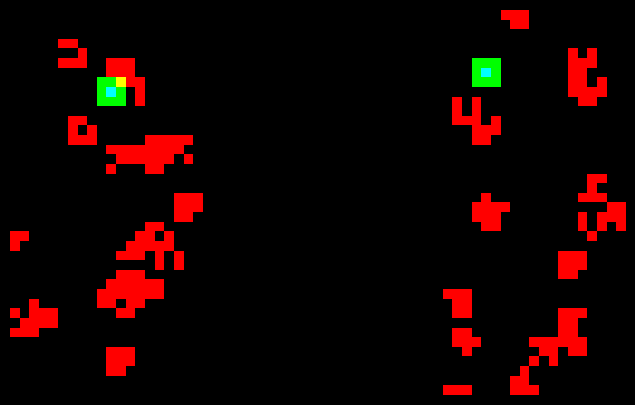

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i, mace in enumerate(maces):
    agent_position = spnav_maces.free(mace)  # Get a free position for the agent
    near_area = spnav_maces.near(mace, agent_position)  # Get the near area around the agent

    # Combine mace, agent position, and near area for visualization
    spnav_maces.plot(mace, position=agent_position, near_area=near_area, ax=ax[i])

plt.show()

In [7]:
def plot_networks(mace, entorhinal, sensors, embeddings):
    fig, ax = plt.subplots(1, 4, figsize=(10, 8))
    ax[0].imshow(1 - mace.cpu().numpy(), cmap="hot", vmin=0.0, vmax=1.0)
    imgfig = ax[1].imshow(entorhinal, cmap="hot", vmin=0.0, vmax=0.2)
    imgsen = ax[2].imshow(sensors, cmap="hot", vmin=-10.0, vmax=10.0)
    imgemb = ax[3].imshow(embeddings, cmap="hot", vmin=0.0, vmax=0.2)
    fig.tight_layout()

    # Set the titles and labels for the cognitive map figure
    ax[0].set_title("Real Map")
    ax[1].set_title("Firing Rate Map")
    ax[2].set_title("Sensors Map")
    ax[3].set_title("Embeddings Map")

    # Set the axes to be invisible
    for axi in ax:
        axi.set_xlabel("X-axis"), axi.set_ylabel("Y-axis")
        axi.set_xticks([]), axi.set_yticks([])

    return fig, imgfig, imgsen, imgemb

In [8]:
def signal_loader(n, mace: torch.Tensor, gain=1.0, decay=0.3):
    position = spnav_maces.free(mace)
    for _ in range(n):
        yield gain * spnav_maces.sensor(mace, position, decay).flatten().to(ehc.device)
        # Next position should be near previous, not touching the wall
        position = spnav_maces.random_near(mace, position)

In [9]:
def simulate(n, mace, memory, decoders, gain=10.0, decay=0.3):
    z = torch.zeros(40, 20).detach().cpu().numpy()
    fig, imgfig, imgsen, imgemb = plot_networks(mace, z.copy(), z.copy(), z.copy())

    # Run simulation and update the figure
    for sensors in signal_loader(n, mace, gain, decay):

        # Get the next output from the model
        cmap, embedding = model(sensors, memory)
        cmap = decoders[0](cmap).reshape(40, 20)  # Reshape to match the image size
        embedding = decoders[1](embedding).reshape(40, 20)  # Reshape to match the image size
        sensors = sensors.reshape(40, 20)  # Reshape to match the image size

        # Update the weights for mapping, embedding, and inhibitory
        update_weights(model)

        # Update the images data
        imgfig.set_data(cmap.cpu().numpy())  # Update the image data
        imgsen.set_data(sensors.cpu().numpy())  # Update the sensors data
        imgemb.set_data(embedding.cpu().numpy())  # Update the embedding data

        # Clear the previous output and display the updated figure
        clear_output(wait=True)
        display(fig)  # Display the updated figure
        plt.pause(0.01)  # Pause to allow the figure to update

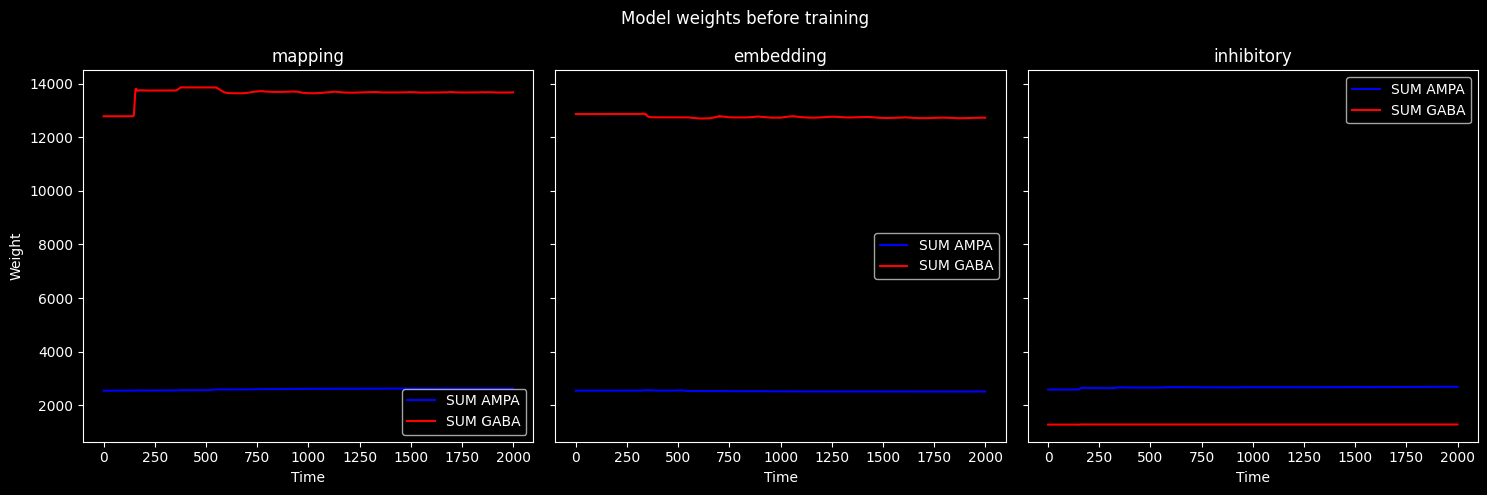

In [10]:
memory_0 = 0.2 * torch.ones(800, device=ehc.device).detach()
for sensors in signal_loader(2000, maces[0], gain=0.0, decay=0.0):
    cmap, embedding = model(sensors, memory_0)
    update_weights(model)

plot_weights("Model weights before training")

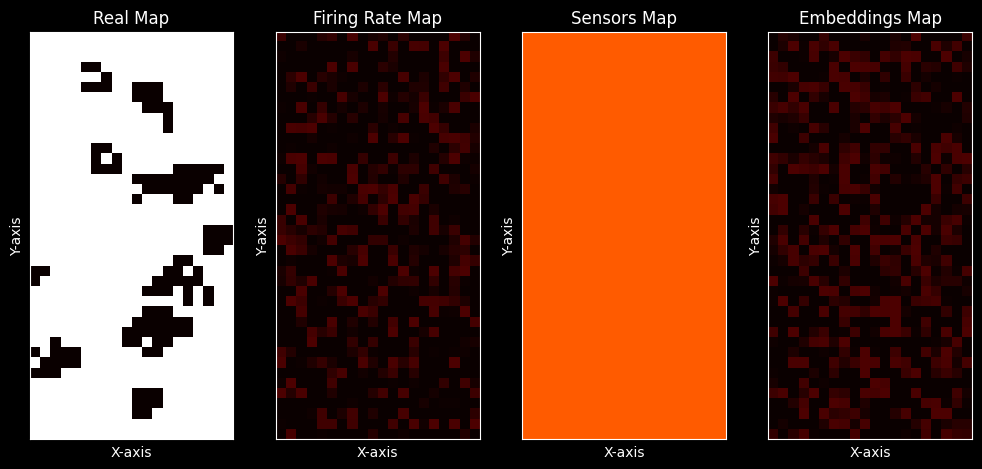

In [11]:
simulate(200, maces[0], memory_0, decoders, gain=0.0)

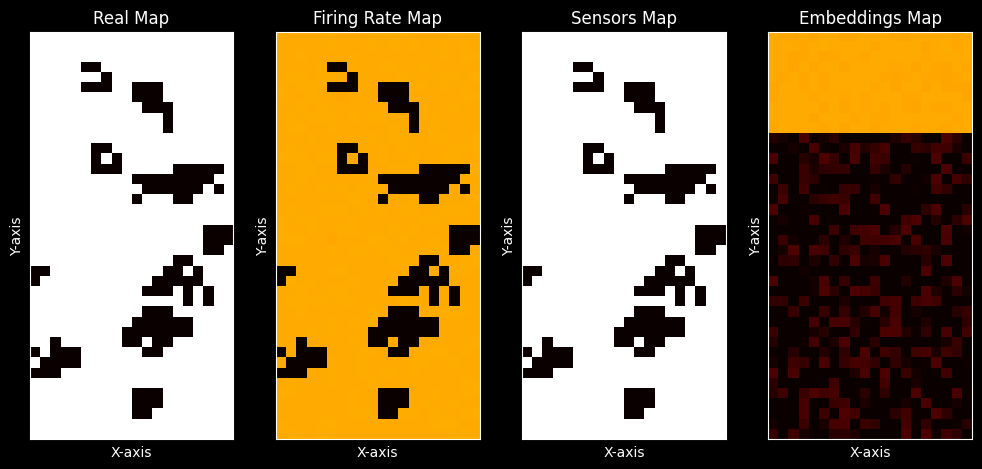

In [12]:
memory_1 = torch.zeros(800, device=ehc.device).detach()
memory_1[:200], memory_1[200:] = 10.0, 0.1
simulate(200, maces[0], memory_1, decoders, gain=10.0, decay=0.0)

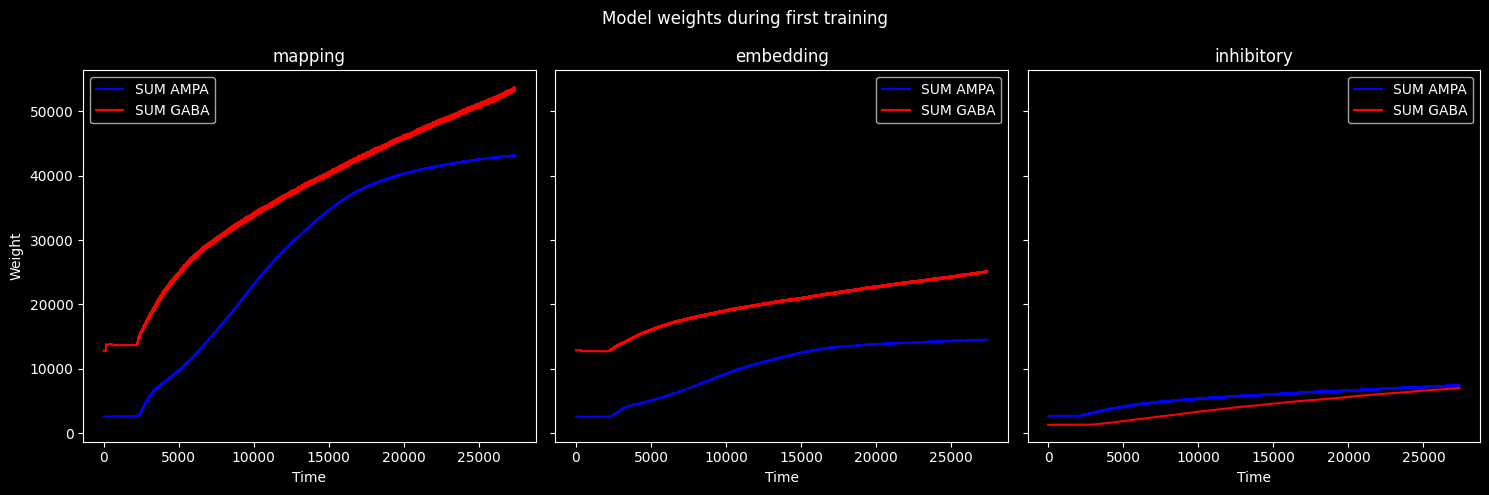

In [13]:
for sensors in signal_loader(25000, maces[0], gain=10.0, decay=0.0):
    cmap, embedding = model(sensors, memory_1)
    update_weights(model)

plot_weights("Model weights during first training")

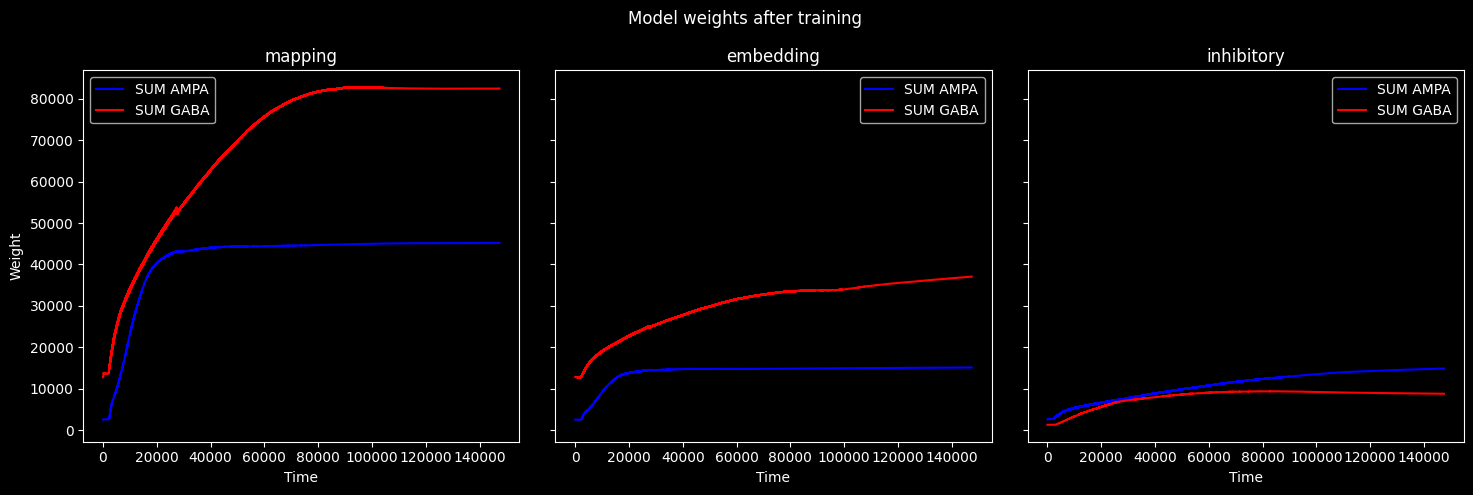

In [14]:
for sensors in signal_loader(120000, maces[0], gain=0.0, decay=0.0):
    cmap, embedding = model(sensors, memory_0)
    update_weights(model)

plot_weights("Model weights after training")

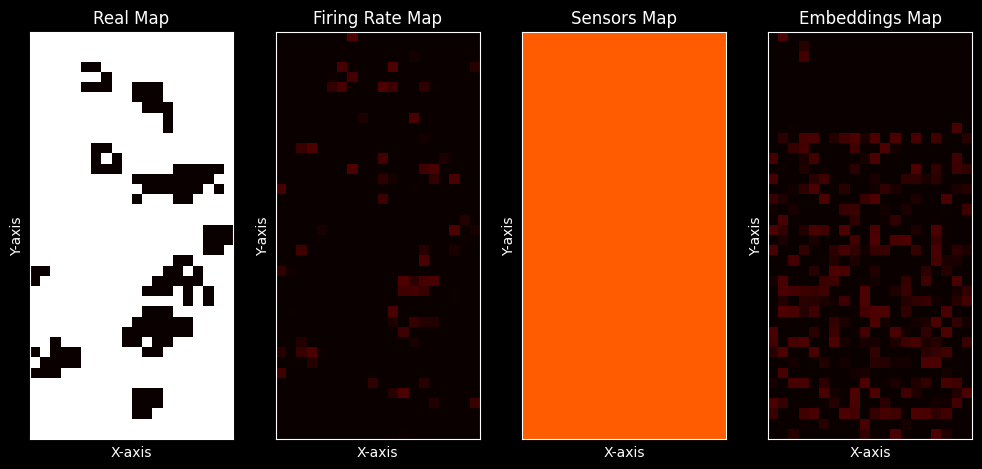

In [15]:
simulate(200, maces[0], memory_0, decoders, gain=0.0)

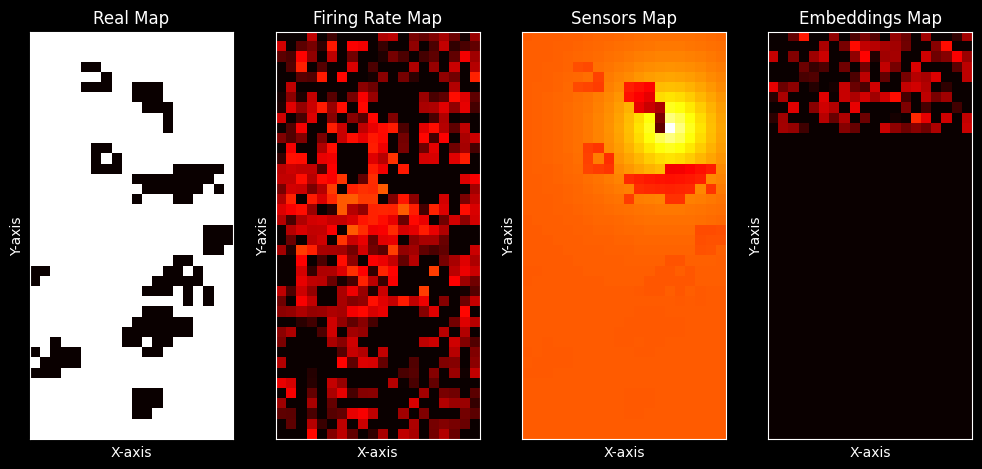

In [16]:
simulate(800, maces[0], memory_0, decoders, gain=10.0)

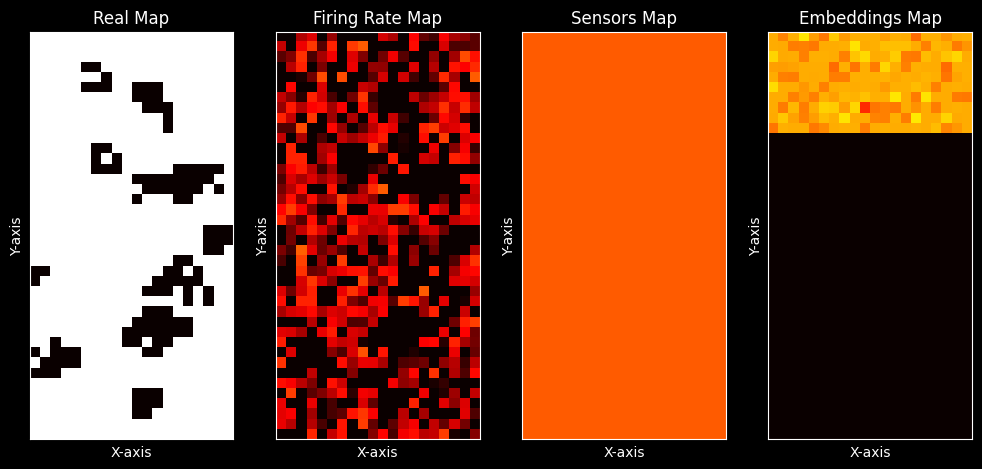

In [17]:
simulate(200, maces[0], memory_1, decoders, gain=0.0)

In [18]:
for sensors in signal_loader(1000, maces[0], gain=0.0):
    cmap, embedding = model(sensors, memory_0)

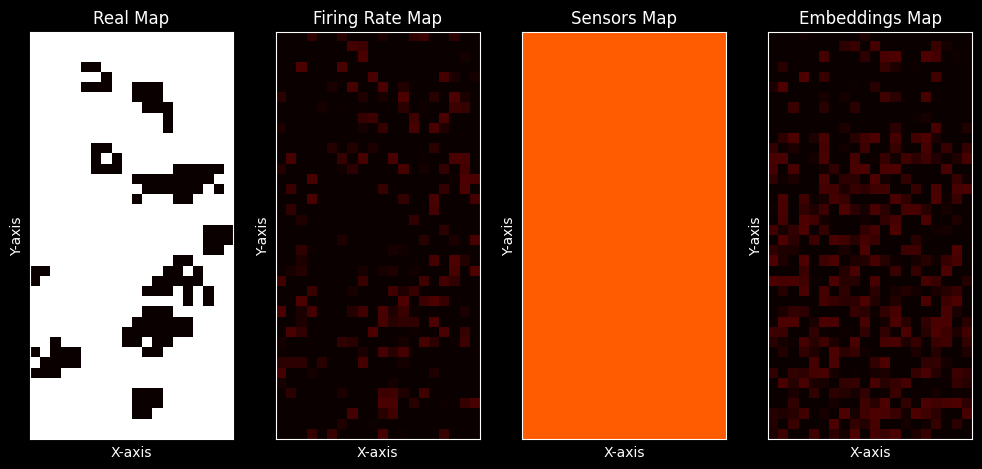

In [19]:
simulate(200, maces[0], memory_0, decoders, gain=0.0)

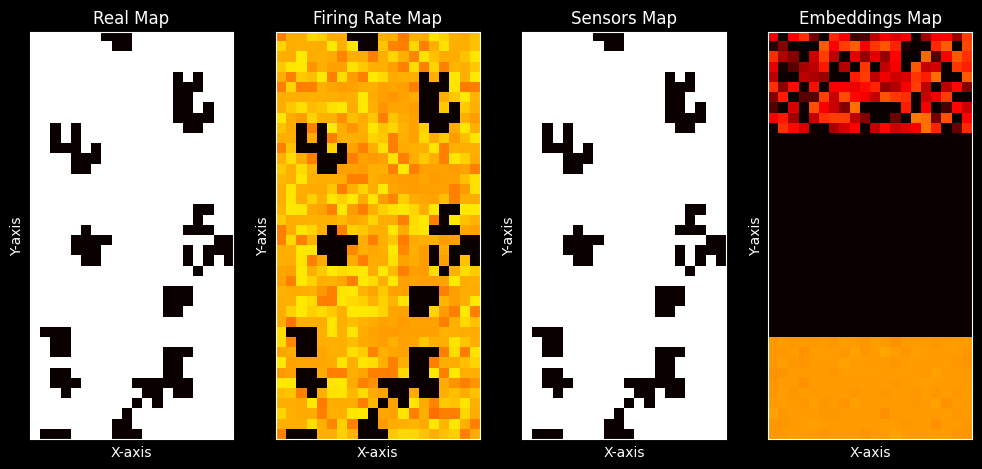

In [20]:
memory_2 = torch.zeros(800, device=ehc.device).detach()
memory_2[:-200], memory_2[-200:] = 0.1, 10.0
simulate(200, maces[1], memory_2, decoders, gain=10.0, decay=0.0)

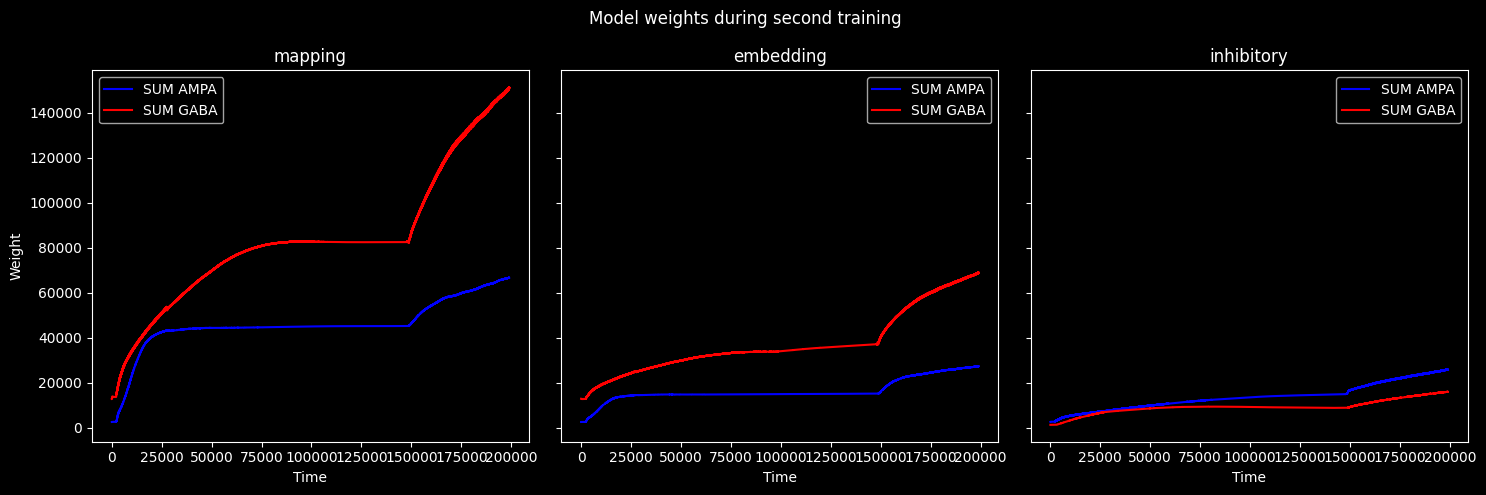

In [21]:
for sensors in signal_loader(50000, maces[1], gain=10.0, decay=0.0):
    cmap, embedding = model(sensors, memory_2)
    update_weights(model)

plot_weights("Model weights during second training")

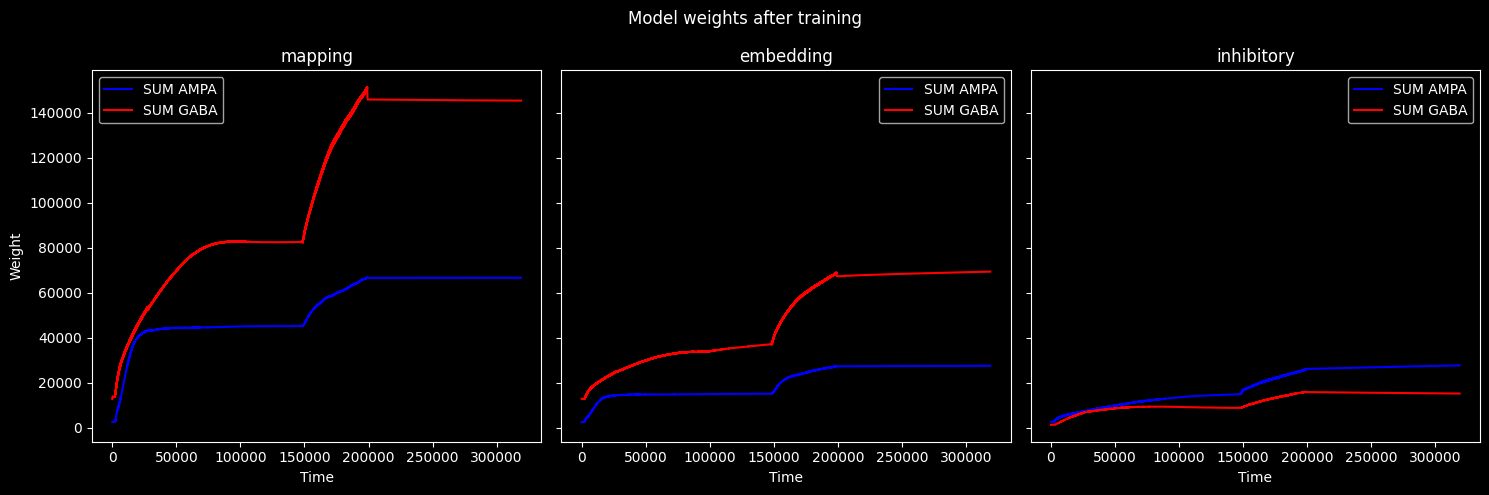

In [22]:
for sensors in signal_loader(120000, maces[1], gain=0.0, decay=0.0):
    cmap, embedding = model(sensors, memory_0)
    update_weights(model)

plot_weights("Model weights after training")

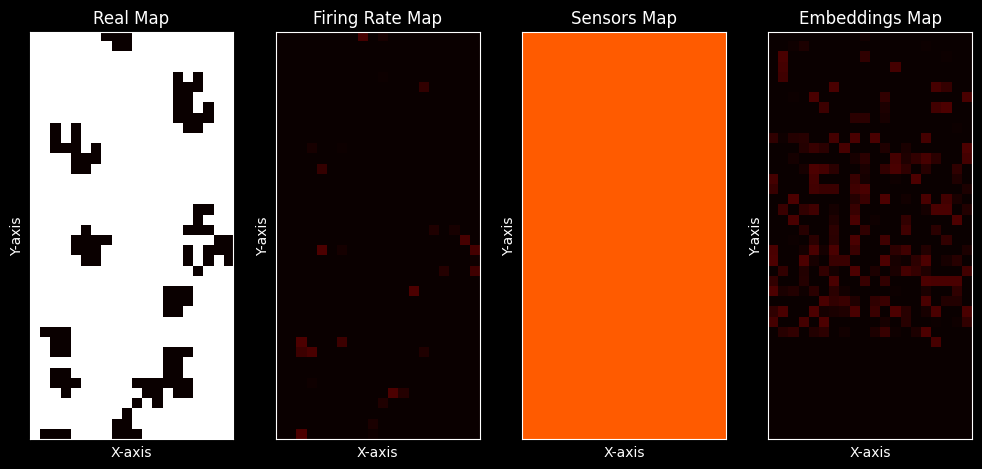

In [23]:
simulate(200, maces[1], memory_0, decoders, gain=0.0)

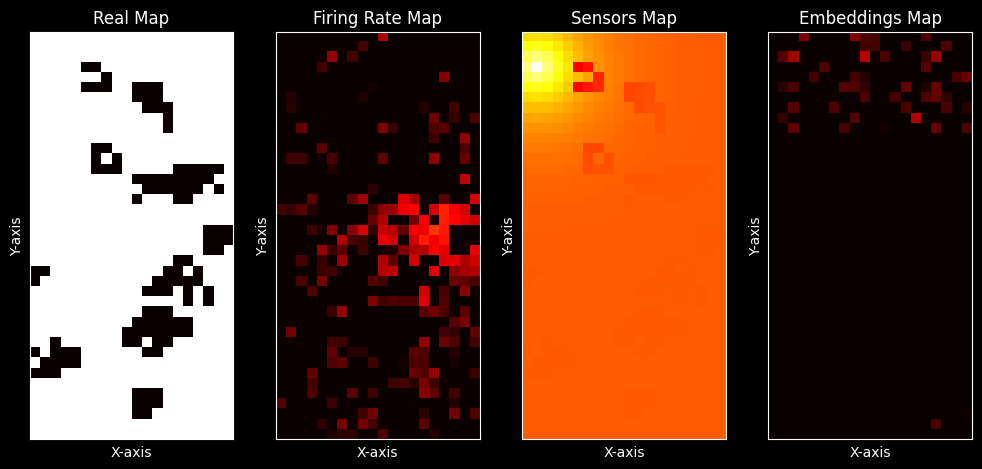

In [24]:
simulate(800, maces[0], memory_0, decoders, gain=10.0)